In [1]:
import numpy as np
import gurobipy as gp
from algorithms import *

Variables to be used to generate nodes and cluster

In [2]:
np.random.seed(42)

# Number of nodes
n = 100
# Number of clusters
p = 20

capacity_mean = 10
capacity_stddev = 2
weight_mean = 1
weight_stddev = 0.1
lambda_param = 0.5

Generate random nodes, capacities, and weights

In [3]:
np.random.seed(42)

# Generate 2D nodes and random capacities for clusters
nodes, capacities = generate_instances(n, p, capacity_mean, capacity_stddev)
# Generate random weight for each node
weights = generate_weights(n, weight_mean, weight_stddev)

Run CCP - Gurobi clustering algorithm

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-06
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2101 rows, 2100 columns and 6020 nonzeros
Model fingerprint: 0x891b22d5
Variable types: 0 continuous, 2100 integer (2100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-04, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 102.9494502
Presolve removed 1 rows and 80 columns
Presolve time: 0.03s
Presolved: 2100 rows, 2020 columns, 6000 nonzeros
Variable types: 0 continuous, 2020 integer (2020 binary)
Found heuristic solution: objective 60.2729236

Root relaxation: objective -1.334751e+01, 714 iterations, 0.06 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

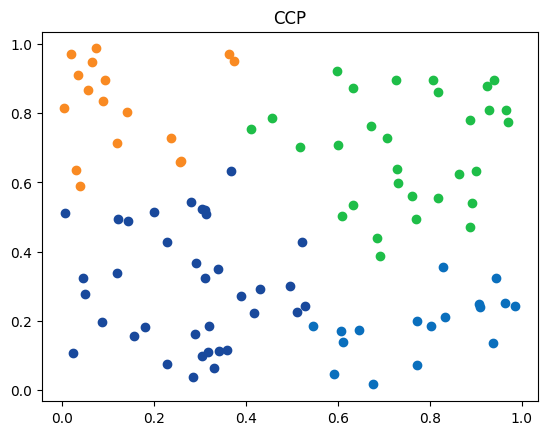

Objective Value:  -13.347509902207758


In [4]:
ccp_clusters, ccp_time, obj_val = solve_model(nodes, capacities, weights, lambda_param,'ccp')
print("Elapsed time:",ccp_time,'s')
plot_clusters(ccp_clusters,nodes,'CCP')
print("Objective Value: ",obj_val)

Calculate In Sample Stability for CCP - Gurobi

In [5]:
insample_stability_score = insample_stability(ccp_clusters, nodes, capacities, weights, lambda_param, num_runs=10)
print("Insample Stability:",insample_stability_score)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2101 rows, 2100 columns and 6020 nonzeros
Model fingerprint: 0x891b22d5
Variable types: 0 continuous, 2100 integer (2100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-04, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 102.9494502
Presolve removed 1 rows and 80 columns
Presolve time: 0.01s
Presolved: 2100 rows, 2020 columns, 6000 nonzeros
Variable types: 0 continuous, 2020 integer (2020 binary)
Found heuristic solution: objective 60.2729236

Root relaxation: objective -1.334751e+01, 714 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -13.3475099  -13.3475

Calculate Out Sample Stability for CCP - Gurobi

In [6]:
outsample_stability_score = outsample_stability(n, p, weight_mean, weight_stddev, capacity_mean, capacity_stddev, lambda_param, num_runs=10)

print("Outsample Stability:",outsample_stability_score)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1471 rows, 1470 columns and 4220 nonzeros
Model fingerprint: 0x98cd264e
Variable types: 0 continuous, 1470 integer (1470 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-05, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 105.3960059
Presolve removed 1 rows and 50 columns
Presolve time: 0.01s
Presolved: 1470 rows, 1420 columns, 4200 nonzeros
Variable types: 0 continuous, 1420 integer (1420 binary)
Found heuristic solution: objective 72.4427842

Root relaxation: objective -6.315591e+00, 315 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      -6.3155906   -6.3155

Calculate VSS for CCP - Gurobi

In [7]:
num_simulations = 10
np.random.seed(42)
VSS = calculate_VSS(n, p, capacity_mean, capacity_stddev, weight_mean, weight_stddev, lambda_param, num_simulations)
print(f"The Value of Stochastic Solution (VSS) is {VSS:.2f}")

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2101 rows, 2100 columns and 6020 nonzeros
Model fingerprint: 0x891b22d5
Variable types: 0 continuous, 2100 integer (2100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-04, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 102.9494502
Presolve removed 1 rows and 80 columns
Presolve time: 0.02s
Presolved: 2100 rows, 2020 columns, 6000 nonzeros
Variable types: 0 continuous, 2020 integer (2020 binary)
Found heuristic solution: objective 60.2729236

Root relaxation: objective -1.334751e+01, 714 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -13.3475099  -13.3475

Run K-Means with Capacity Constraints (Heuristic) clustering algorithm

c:\Users\asus rog\Desktop\stochastic-optimization\algorithms\kmcc_clustering.py:25: RuntimeWarning: invalid value encountered in divide
  center_nodes[i] /= total_weight[i]


Elapsed time: 1.2970364093780518 s


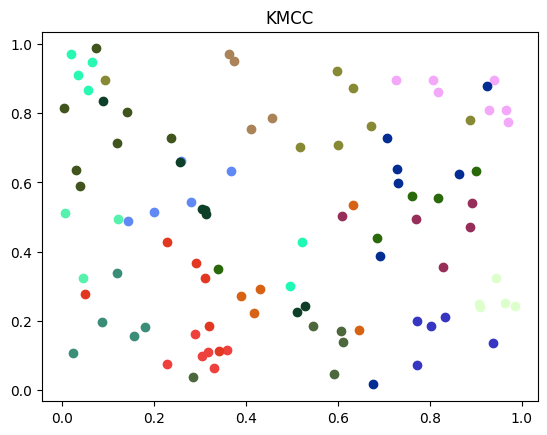

Objective Value 2.648963362660507


In [8]:
kmcc_clusters, kmcc_time, wcss = kmcc_clustering(nodes, capacities, weights)
print("Elapsed time:",kmcc_time,'s')
plot_clusters(kmcc_clusters,nodes,'KMCC')
print("Objective Value",wcss)

In [9]:
kmcc_insample_stability_score = KMCC_insample_stability(kmcc_clusters, nodes, capacities, weights, num_runs=3)
print("KMCC Insample Stability:",kmcc_insample_stability_score)

KMCC Insample Stability: 0.40930169840988556


In [10]:
kmcc_outsample_stability_score = KMCC_outsample_stability(n, p, weight_mean, weight_stddev, capacity_mean, capacity_stddev, num_runs=10)

print("KMCC Outsample Stability:",kmcc_outsample_stability_score)

KMCC Outsample Stability: 1.0
